# Machine Learning Modeling

---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import joblib

# shows plots in jupyter notebook
%matplotlib inline

# set plot style
sns.set(color_codes=True)

In [5]:
clients_df = pd.read_csv('../data/processed_data.csv')
print('Shape of the dataset: ', clients_df.shape)
clients_df.head()

Shape of the dataset:  (14606, 18)


,cons_12m,cons_gas_12m,off_peak_forecast_energy,off_peak_forecast_power,imp_cons,margin_net_pow_ele,net_margin,pow_max,churn,off_peak_mean_energy,off_peak_mean_power,off_peak_diff_energy,off_peak_diff_power,origin,channel,discount_energy,active_products,antiquity
0,0,54946,0.114481,40.606701,0.00,25.44,678.99,43.648,1,0.124787,40.942265,0.020057,3.700961,lxidpiddsbxsbosboudacockeimpuepw,foosdfpfkusacimwkcsosbicdxkicaua,NO_DISCOUNT,MULTIPLE,RECENT
1,4660,0,0.145711,44.311378,0.00,16.38,18.89,13.800,0,0.149609,44.311375,-0.003767,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,MISSING,NO_DISCOUNT,ONE,OLD
2,544,0,0.165794,44.311378,0.00,28.60,6.60,13.856,0,0.170512,44.385450,-0.004670,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,foosdfpfkusacimwkcsosbicdxkicaua,NO_DISCOUNT,ONE,OLD
3,1584,0,0.146694,44.311378,0.00,30.22,25.46,13.200,0,0.151210,44.400265,-0.004547,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,lmkebamcaaclubfxadlmueccxoimlema,NO_DISCOUNT,ONE,OLD
4,4425,0,0.116900,40.606701,52.32,44.91,47.98,19.800,0,0.124174,40.688156,-0.006192,0.162916,kamkkxfxxuwbdslkwifmmcsiusiuosws,MISSING,NO_DISCOUNT,ONE,OLD


---

## Data Preprocessing

In [7]:
def split_data(X, y):
    """
    Split the data into train and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [8]:
X = clients_df.drop('churn', axis=1)
y = clients_df['churn']

# apply log transformation
X[['cons_12m', 'cons_gas_12m', 'imp_cons', 'pow_max']] = np.log(X[['cons_12m', 'cons_gas_12m', 'imp_cons', 'pow_max']] + 1)

# split data into train and test sets
X_train, X_test, y_train, y_test = split_data(X, y)
print('Shape of the train set: ', X_train.shape, y_train.shape)
print('Shape of the test set: ', X_test.shape, y_test.shape)

Shape of the train set:  (11684, 17) (11684,)
Shape of the test set:  (2922, 17) (2922,)


In [9]:
X.dtypes

cons_12m                    float64
cons_gas_12m                float64
off_peak_forecast_energy    float64
off_peak_forecast_power     float64
imp_cons                    float64
margin_net_pow_ele          float64
net_margin                  float64
pow_max                     float64
off_peak_mean_energy        float64
off_peak_mean_power         float64
off_peak_diff_energy        float64
off_peak_diff_power         float64
origin                       object
channel                      object
discount_energy              object
active_products              object
antiquity                    object
dtype: object

In [10]:
# create a preprocessor for categorical and numerical features: OHE and Standardization
categories = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=['float64']).columns.tolist()

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
standard_scaler = StandardScaler()

---

## Baseline Model


In [11]:
def print_scores(y_true, y_pred):
    print(f'Accuacy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'F1: {f1_score(y_true, y_pred, zero_division=0):.2f}')

In [12]:
# first baseline
baseline_1_guesses = np.random.choice([0, 1], size=len(clients_df), p=[.9, .1])
print_scores(clients_df.churn, baseline_1_guesses)

Accuacy: 0.82
Precision: 0.09
Recall: 0.09
F1: 0.09


## Logistic Regression


In [13]:
def try_model(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('Train scores:')
    print_scores(y_train, y_train_pred)
    print('\r\n')
    print('Test scores:')
    print_scores(y_test, y_test_pred)

In [14]:
lreg = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('one_hot_encoder', one_hot_encoder, categories),
        ('standard_scaler', standard_scaler, numerical)
    ])),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

try_model(lreg)

Train scores:
Accuacy: 0.90
Precision: 0.36
Recall: 0.01
F1: 0.01


Test scores:
Accuacy: 0.90
Precision: 0.00
Recall: 0.00
F1: 0.00


## DECISION TREE

In [15]:
dt = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('one_hot_encoder', one_hot_encoder, categories),
    ], remainder='passthrough')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

try_model(dt)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.84
Precision: 0.22
Recall: 0.25
F1: 0.23


In [16]:
def plot_feature_importances(importances, columns):
    '''Function to be used for plotting feature importances for the tree-based models'''
    # sort indices in descending order of feature importances
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    columns = columns[indices]
    # plot
    plt.figure(figsize=(8, 8))
    sns.barplot(x=importances, y=columns)
    plt.show()

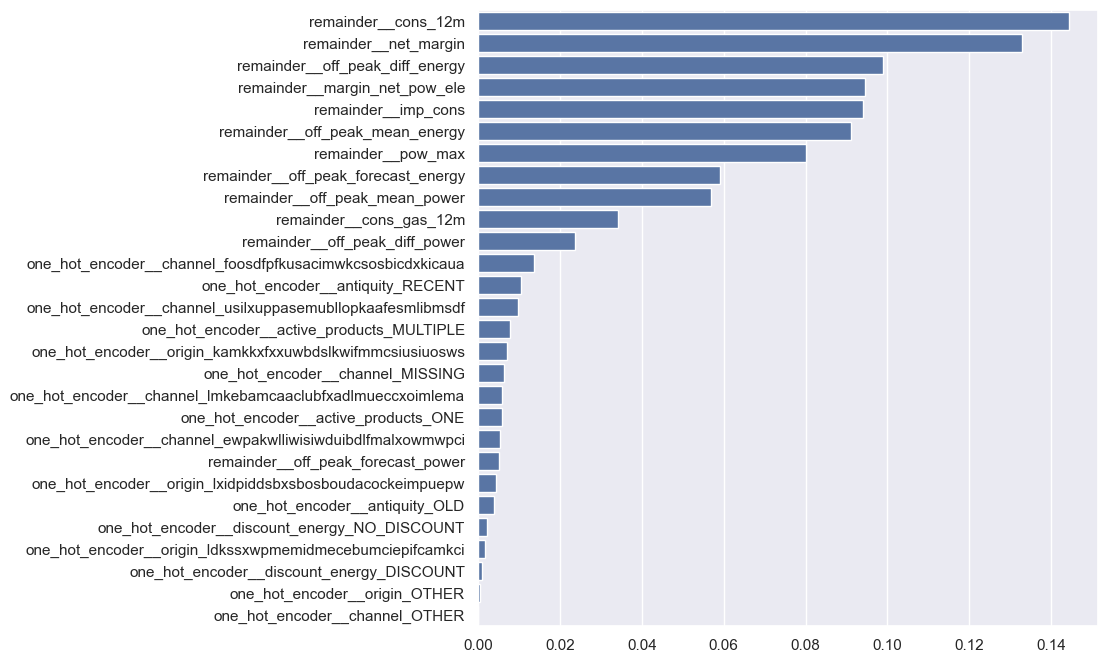

In [17]:
plot_feature_importances(dt.named_steps['classifier'].feature_importances_, dt.named_steps['preprocessor'].get_feature_names_out())

In [18]:
X.drop(['origin', 'channel', 'discount_energy', 'active_products', 'antiquity'], axis=1, inplace=True)

In [19]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [20]:
dt = DecisionTreeClassifier(random_state=42)
try_model(dt)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.84
Precision: 0.22
Recall: 0.25
F1: 0.23


In [21]:
# define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 7}]
}

# create classifier
dt = DecisionTreeClassifier(random_state=42)

# create GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')

# fit object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 7}, 'max_depth': 10, 'min_samples_split': 7}
Best Score:  0.35506607929515416


In [22]:
dt = grid_search.best_estimator_

try_model(dt)

Train scores:
Accuacy: 0.79
Precision: 0.26
Recall: 0.64
F1: 0.37


Test scores:
Accuacy: 0.74
Precision: 0.17
Recall: 0.42
F1: 0.24


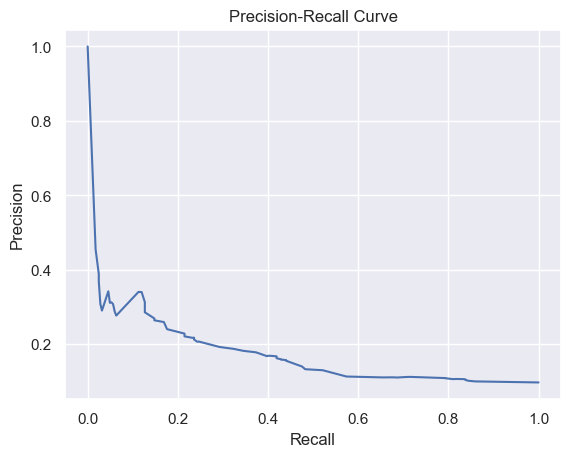

In [23]:
# predict probabilities for the positive class
y_scores = dt.predict_proba(X_test)[:, 1]

# calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [24]:
# apply threshold
y_pred = (y_scores >= 0.62).astype(int)

# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2638
           1       0.21      0.24      0.22       284

    accuracy                           0.84      2922
   macro avg       0.56      0.57      0.57      2922
weighted avg       0.85      0.84      0.84      2922



## Random Forest

In [25]:
rf = RandomForestClassifier(random_state=42)

try_model(rf)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.91
Precision: 0.86
Recall: 0.08
F1: 0.15


In [26]:
# define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'max_features': ['sqrt', None],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 7}]
}

# create classifier
rf = RandomForestClassifier(random_state=42)

# create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', n_jobs=-1)

# fit object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 7}, 'max_depth': 5, 'max_features': None, 'min_samples_split': 2}
Best Score:  0.3709251101321586


In [27]:
rf = grid_search.best_estimator_

try_model(rf)

Train scores:
Accuacy: 0.78
Precision: 0.21
Recall: 0.47
F1: 0.29


Test scores:
Accuacy: 0.76
Precision: 0.17
Recall: 0.38
F1: 0.24


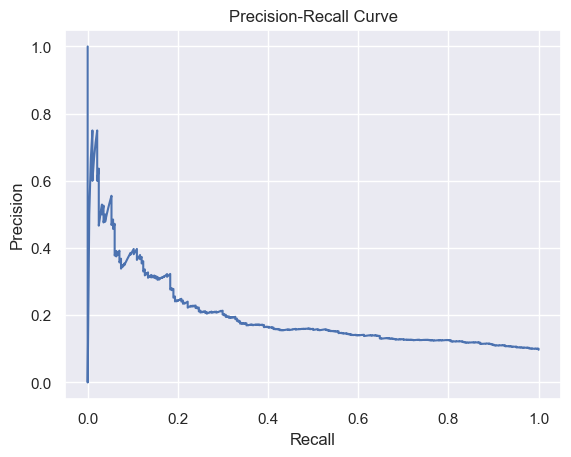

In [28]:
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [29]:
y_pred = (y_scores >= 0.53).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2638
           1       0.20      0.31      0.24       284

    accuracy                           0.81      2922
   macro avg       0.56      0.59      0.57      2922
weighted avg       0.85      0.81      0.83      2922



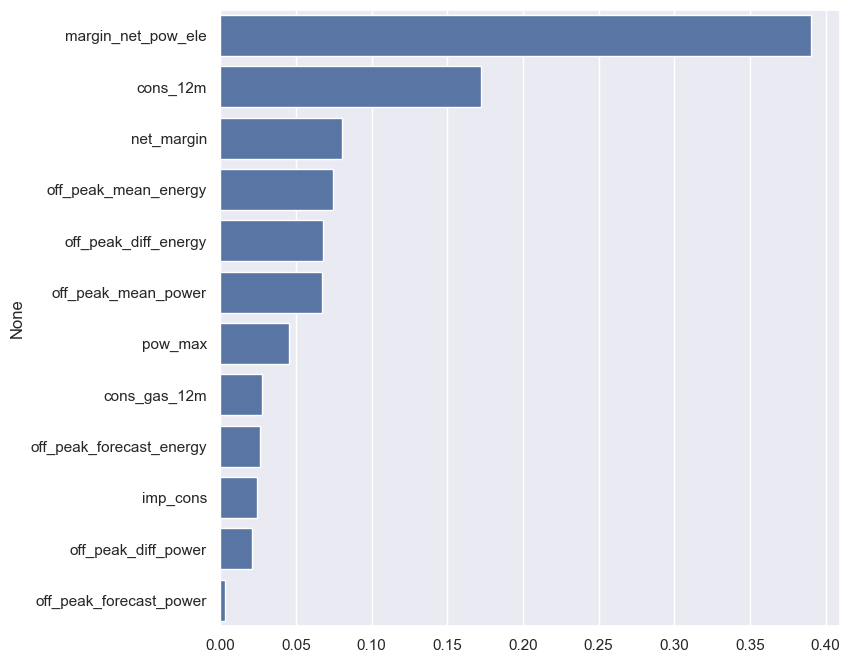

In [30]:
plot_feature_importances(rf.feature_importances_, X_train.columns)